# NBA Play-Off Simulation
----
Anton Buguev, Innopolis University

December 2023

Basketball is one of the most popular sports in the world [(1)](https://news.topsport.com.au/ranked-the-worlds-most-popular-sports/), [(2)](https://thesporting.blog/blog/the-most-popular-sports-in-the-world) while the most popular basketball league is definitely the National Basketball Association (NBA) [(3)](https://www.onlinebettingacademy.com/blog/2023/06/top-ten-basketball-leagues). Images below show only small part of the best NBA players that a lot of unfamiliar people probably know as well. These players have already earned (or will earn) the place in NBA Hall of Fame.


| <img src="images/kobe_shaq.png" height="350" alt="Kobe Bryant and Shaquille O'Neal"/> | <img src="images/michael.png" height="350" alt="Michael Jordan"/> | 
|:--:|:--:| 
| <font size="5">Kobe Bryant (8) and Shaquille O'Neal (34)</font>| <font size="5">Michael Jordan</font> |
| <img src="images/lebron_wade.png" height="350" alt="LeBron James"/> | <img src="images/tima.png" height="350" alt="Stephen Curry"/> | 
| <font size="5">LeBron James (6) and Dwyane Wade (3)</font>| <font size="5">Timofey Mozgov - 2015/16 NBA champion</font> |

*P.S. There was a typo in Mozgov's score, he definitely earned less points, it is just a joke*
<!-- *Table (1): One of the best and famous NBA players* -->


Any basketball fan would love to attend the NBA match in real life. Unfortunately, a lot of fans (like me) live on other half of the world, which makes it difficult to attend or even watch matches online due to the different time-zones. For example, if you live in Moscow time-zone, then matches start around **1AM** and end at **7AM** (if you want to watch several games). Hence, we either have to sacrifice our sleep schedule or skip match of the favourite team. What would be even more sad if you decide to wake up early and your team loses.

Therefore, the idea for my project arised. What if I can predict the match outcome (at least approximately) and decide if I want to sacrifice my sleep for that night. However, predicting each match would be the tedious task. Moreover, I need some data to use as foundation for predictions and since each season players switch teams, predictions would be wrong for first games. Hence, I decided to simulate only Play-Off stages. The basic steps are the following:
1. Extract mathces results for given season with detailed statistics;
2. Train Machine Learning (ML) model on that data;
3. Insert teams participating in Play-Off;
4. Simulate each Play-off round for each pair of teams eventually predicting the champion.

So let us get started.


## Extra class for colourful output

In [1]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Part 1. Model selection

First, we need to select appropriate ML model for correct predictions. Since we just need to predict which team out of 2 wins in a match, this is just classification problem, therefore I used standard models for binary classification:
- Logistic regression
- Naïve Bayes
- K-nearest neighbours (KNN)
- Decision Tree
- Random Forest
- Support Vector Classifier (SVC)

For each of the models we will tune hyper-parameters and check which of them shows the best performance.

### Import data

For this project I used dataset from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data) that was collected from website with detailed statistic [Basketball reference](https://www.basketball-reference.com/). The main datasets that we will use are `games.csv` (games information) and `teams.csv` (teams information for convenient visualization). However, I added 2 extra files with season schedule (`season_schedule.csv`) and teams participating in Play-Off for given seasons (`play_off_teams.csv`). Of course Play-off pairs generation may be automated, because there is table with team ranking but we would need to apply many filters to get useful information and handle situations if some teams have the same number of wins in season, so let us use hand-written data for now.

#### Games information

Let us ppreprocess data right away:
* Scale columns with team IDs because initially this column contained 10-digit numbers, but there are only 30 teams in NBA
* Drop columns **TEAM_ID_home** and **TEAM_ID_away** because the just duplicated teams IDs from columns **HOME_TEAM_ID** and **VISITOR_TEAM_ID** respectively
* Table contains incomplete information for games before 2004, so we keep games only after that year

Now let us analyze the data  to understand what we have here 
+ **GAME_DATE_EST**: date of the game, this will be used to distinguish regular season games from play-off games
- **GAME_ID**: not really useful column, we will drop it later
- **GAME_STATUS_TEXT**: also not useful column, *Final* just means that game has finished (*e.g.* we load data during the game, the status would be different)
+ **HOME_TEAM_ID**: ID of home team, we will use it
+ **VISITOR_TEAM_ID**: ID of visitor team, also will use it
+ **SEASON**: season year, will also be used to sort games for given season (but can use just first column)
- **PTS_home**: number of points home team earned, this column will not be used because in that case all other columns are not neccessary
+ **FG_PCT_home**: percentage of successfull shot attempts of home team
+ **FT_PCT_home**: percentage of successfull free-throw (after foul) attempts of home team
+ **FG3_PCT_home**: percentage of successfull 3-point shot attempts of home team
+ **AST_home**: number of assists of home team, it shows how good the ball movement is, so we will use this column
+ **REB_home**: number of rebounds of home team, it shows how good team gets the ball after failed shot attempt during attack and defense, so we also need this column
- **PTS_away**: number of points visitor team earned, also will not be used by the same reason
+ **FG_PCT_away**: percentage of successfull shot attempts of visitor team
+ **FT_PCT_away**: percentage of successfull free-throw (after foul) attempts of visitor team
+ **FG3_PCT_away**: percentage of successfull 3-point shot attempts of visitor team
+ **AST_away**: number of assists of visitor team
+ **REB_away**: number of rebounds of visitor team
+ **HOME_TEAM_WINS**: 1 - home team wins, 0 - otherwise. This will be our target

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

df_games = pd.read_csv('data/games.csv').drop(["TEAM_ID_home", "TEAM_ID_away"], axis=1) # open data without 2 columns wit hteam IDs
df_games = df_games.loc[df_games["SEASON"] >= 2004] # store games starting from season 2004

scaler = MinMaxScaler()
cols_to_norm = ["HOME_TEAM_ID", "VISITOR_TEAM_ID"]
df_games.loc[:, cols_to_norm] = scaler.fit_transform(df_games.loc[:, cols_to_norm]) # scale team IDs
df_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0.103448,0.758621,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,0.862069,0.931034,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,0.068966,0.413793,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,0.620690,0.965517,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,0.000000,0.137931,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,0.000000,0.103448,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,0.137931,0.931034,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,0.344828,0.206897,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,0.827586,0.724138,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.725,0.385,18.0,45.0,1


#### Teams information
From this table we only need column with team ID and corresponding abbreviation or nickname just for convenient demonstration

In [3]:
df_teams = pd.read_csv('data/teams.csv')
df_teams.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_teams.loc[:, ["TEAM_ID"]])
df_teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,0.000000,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,0.034483,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,0.103448,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,0.137931,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,0.172414,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


#### Seasons dates
This is custom-made dataset with period of regular season (without preseason games or play-off). I decided to exclude preseason games because usually teams do not use full power during these games, they are needed to test new combinations. And play-off is totally different thing since teams know their opponent and prepare carefully for each game and our goal is to predict play-off results based on regular season performance.

In [4]:
season_schedule = pd.read_csv("data/season_schedule.csv")
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
START: beginning date of regular mathces
END: beginning date of play-off
"""
season_schedule.head()

,SEASON,START,END
0,2004,2004-11-02,2005-04-23
1,2005,2005-11-01,2006-04-22
2,2006,2006-10-31,2007-04-21
3,2007,2007-10-30,2008-04-19
4,2008,2008-10-28,2009-04-18


### Test different models for all seasons

Let us use only specified columns for training. *i.e.* team IDs, their statistics in each game and as target 0/1 to represent which team won the match.

In [5]:
# which columns to use for predictions
useful_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                  'FG_PCT_home', 'FT_PCT_home',
                  'FG3_PCT_home', 'AST_home', 'REB_home',
                  'FG_PCT_away', 'FT_PCT_away',
                  'FG3_PCT_away', 'AST_away', 'REB_away',
                  'HOME_TEAM_WINS']

As mentioned before, we are going to try different models with different hyperparameters using *Grid search*. The algorithm for model selection is following:
1. Get all regular season games for each season
2. Split data into train and test sets
3. Normalize columns (number of assists and rebounds)
4. Train each model on given data and compute test score using different metrics (*accuracy, precision, recall, F1*)
5. Find mean score of each metric of each model
6. Select the best model

In [6]:
def filter_season_games(season_year: int) -> pd.DataFrame:
    # This function takes season_year as an argument and returns allregular season games for that season
    season_start = season_schedule.loc[season_schedule["SEASON"] == season_year]["START"].iloc[0]
    season_end = season_schedule.loc[season_schedule["SEASON"] == season_year]["END"].iloc[0]
    
    return df_games.loc[(df_games["GAME_DATE_EST"] >= season_start)
                        & (df_games["GAME_DATE_EST"] < season_end),
                        useful_columns]

In [7]:
# hyper-parameters for models
dec_tree_params = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random']}
rand_forest_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators': [i for i in range(100, 501, 100)]}
svc_params = {'kernel': ['poly', 'rbf'],
              'degree': [i for i in range(3, 6)]}
knn_params = {'n_neighbors': [i for i in range(3, 6)],
              'weights': ['uniform', 'distance']}
nb_params = {'var_smoothing': np.linspace(1e-5, 1, 10)}
logreg_params = {'penalty': ['l2', None]}

# models to select from
models = {LogisticRegression: ('LogReg', logreg_params),
          DecisionTreeClassifier: ('DecTree', dec_tree_params),
          RandomForestClassifier: ('RandForest', rand_forest_params),
          SVC: ('SVC', svc_params),
          KNeighborsClassifier: ('KNN', knn_params),
          GaussianNB: ('NaiveBayes', nb_params)}

# metrics to analyze models
metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
# store scores for each metric for each model
test_results = {model: {metric: [] for metric in metrics.keys()} for model in models.keys()}
cols_to_norm = ['AST_home','REB_home', 'AST_away', 'REB_away']

# iterate over data for each season and try different model
# to select which model performs better on average
for row in tqdm(season_schedule.iterrows()):
    season_year, _, __ = row[1].values
    X = filter_season_games(season_year)
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop(["HOME_TEAM_WINS"], axis=1),
                                                        X["HOME_TEAM_WINS"],
                                                        test_size=0.3,
                                                        random_state=42)
    
    X_train.loc[:, cols_to_norm] = scaler.fit_transform(X_train.loc[:, cols_to_norm])
    X_test.loc[:, cols_to_norm] = scaler.transform(X_test.loc[:, cols_to_norm])
    
    for model in models.keys():
        current_model = model()
        model_params = models[model][1]
        current_model = GridSearchCV(estimator=current_model,
                                         cv=3,
                                         param_grid=model_params,
                                         scoring='accuracy')
        current_model.fit(X_train, y_train)
        
        y_pred = current_model.predict(X_test)
        for metric_name, metric in metrics.items():
            test_results[model][metric_name].append(metric(y_test, y_pred))
    

18it [05:50, 19.45s/it]


### Plot bar diagram with average metrics results for each model

Let us plot diagram with average metrics scores to visualize achieved results and choose the most appropriate model

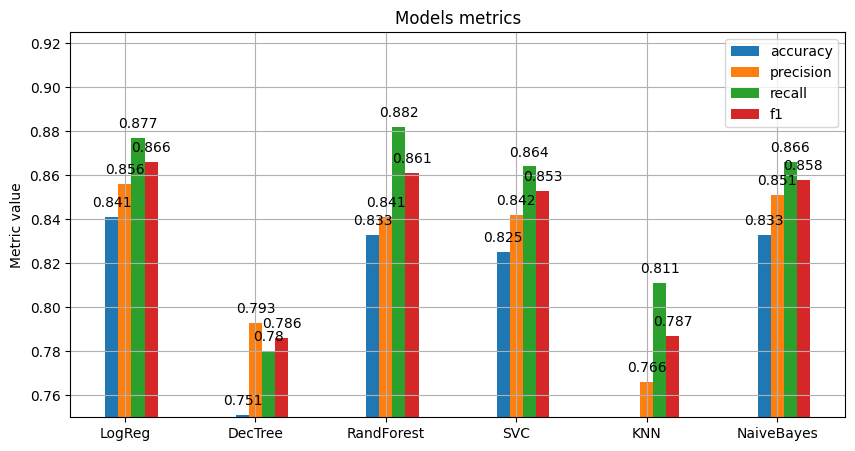

In [8]:
all_results = {metric_name: [] for metric_name in metrics.keys()}

for model, results in test_results.items():
    for metric, value in results.items():
        all_results[metric].append(np.array(value).mean())

x_loc = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in all_results.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel('Metric value')
ax.set_title('Models metrics')
ax.set_xticks(x_loc + width, [v[0] for v in models.values()])
ax.legend()
ax.grid()
ax.set_ylim(0.75, 0.925)

plt.show()

We can see that **Decision Tree** and **KNN** showed worst results in all metrics, hence we immediately drop them. **Random Decision Tree** demonstrated highest `recall` score compared to all models, but it showed sligtly worse results in other metrics, so we cannot pick this model right away either. On average it looks like **Logistic regression** model showed one of the best results, therefore, let us use this model for the predictions.

## Part 2. Simulate Play-Off

After the model has been slected we can move to the actual play-off simulations. But first, let us clarify play-off rules:

- 8 best teams in each conference (east and west) are divided into pairs
- The team that wins 4 mathces moves to the next round (*i.e.* maximum 7 matches for team pair)
- Eventually there is final round for the winners of east and west conferences
- Team that wins 4 matches in the finals becomes NBA champion

After rules are stated, let us define the general algorithm for simulation:

1. Filter games data for selected season
1. Train model on that data
1. Compute average performance per game for each team (*i.e.* average **FG_PCT, FT_PCT**, *etc*)
1. For each team pair we can generate small table with 7 rows of the same format that we used for training. However, teams cannot have the same percatnage of successful shots, number of assists and rebounds. Hence, we need to slightly change these numbers to add variability
1. Predict outcome of these 7 games and identify the winner
1. Repeat steps *4-5* for each team pair **N** number of times (100, for example)
1. Select team with higher number of victories to move to the next round
1. Repeat steps *4-7* for all teams in east and west conferences
1. Simulate final round as in steps *4-6* for reamining team pair

For convenience let us make separate functions for some of the steps. Function to filter games for given season has been defined above (`filter_season_games`), other functions will be defined below.

### Train ML model for given season

In [9]:
def prepare_model(season_year: int) -> LogisticRegression:
    # This function takes season_year as an argument and trains the model on data for that season
    regular_season = filter_season_games(season_year) # get games for given season
    
    regular_season.loc[:, cols_to_norm] = scaler.fit_transform(regular_season.loc[:, cols_to_norm]) # scale specified columns
    X, y = regular_season.drop(["HOME_TEAM_WINS"], axis=1), regular_season["HOME_TEAM_WINS"] # split data into predictors and target

    # train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    
    return model


### Compute average data for each team for a gven season

In [10]:
def compute_statistics(season_year:int=2018) -> pd.DataFrame:
    # This function takes season_year and computes average data for each team
    if 2004 > season_year > 2022:
        print("NO DATA FOR THIS SEASON")
        return
    
    season_data = filter_season_games(season_year) # get games for given season
    
    teams_data = df_teams[["TEAM_ID", "ABBREVIATION"]] # extract team ID and abbreviation from other table 
    
    # columns to be extracted from season_data
    home_features = ['FG_PCT_home', 'FT_PCT_home',
                     'FG3_PCT_home', 'AST_home', 'REB_home']
    away_features = ['FG_PCT_away', 'FT_PCT_away',
                     'FG3_PCT_away', 'AST_away', 'REB_away']

    # for each team compute average values
    for team_row in teams_data.iterrows():
        idx, (team_id, _) = team_row[0], team_row[1].values

        # Get data when given team played at home
        home_data = season_data.loc[season_data["HOME_TEAM_ID"] == team_id, home_features]
        home_data = home_data.rename(columns={f: f[:-5] for f in home_features})

        # Get data when given team played away
        away_data = season_data.loc[season_data["VISITOR_TEAM_ID"] == team_id, away_features]
        away_data = away_data.rename(columns={f: f[:-5] for f in away_features})
        
        # Combine subtables
        temp_data = pd.concat([home_data, away_data])
        for col in temp_data.columns:
            teams_data.loc[idx, [col]] = temp_data.loc[:, [col]].mean()  
          
    local_cols_to_norm = ["AST", "REB"]
    teams_data.loc[:, local_cols_to_norm] = scaler.fit_transform(teams_data.loc[:, local_cols_to_norm]) # scalse columns with assists and rebounds
    
    return teams_data

print("This is the table with average performance of each team in given season")
compute_statistics().head()

This is the table with average performance of each team in given season


,TEAM_ID,ABBREVIATION,FG_PCT,FT_PCT,FG3_PCT,AST,REB
0,0.000000,ATL,0.451780,0.751817,0.350976,0.615385,0.611473
1,0.034483,BOS,0.465829,0.806378,0.363012,0.663625,0.445893
2,0.103448,NOP,0.474561,0.757463,0.344073,0.743155,0.739244
3,0.137931,CHI,0.454183,0.788293,0.349183,0.195567,0.268579
4,0.172414,DAL,0.447659,0.741524,0.341451,0.354628,0.528031


### Simulate play-off round for 2 given teams

Now let us create function to simulate single round for team pair. In real life one of the teams plays at home while the other becomes a visitor. During pay-off each round starts from 2 games in one city, then 2 games in other city, after that visit one another after each game. Let us apply the same order in simulation. Moreover, since we simulate each round **N** number of times, we can start each time in different order, *i.e.*, in one simluation **Team_1** starts round at home while in other it may start as visitor.

In [11]:
home_visitor_order = [True, True, False, False, True, False, True]
scale = 1/4

def simulate_play_off_round(team_pair: list, ml_model: LogisticRegression, season_statistics: pd.DataFrame) -> str:
    # This function takes team pair, pretrained model, stastics of each team for given season
    # and simulates play-off round for this pair (best in 7)
    
    np.random.shuffle(team_pair) # randomly set home and visitor teams
    team1, team2 = team_pair
    if team1 == team2:
        print("YOU ENTERED THE SAME TEAMS")
        return
    
    # extract corresponding average performance for each team
    team1_data = season_statistics.loc[season_statistics["ABBREVIATION"] == team1, :]
    team2_data = season_statistics.loc[season_statistics["ABBREVIATION"] == team2, :]
    
    # initialize columns of new small table
    home_team_id = [] # HOME_TEAM_ID
    away_team_id = [] # VISITOR_TEAM_ID

    fg_pct_home, ft_pct_home, fg3_pct_home = [], [], [] # FG_PCT_home, FT_PCT_home,	FG3_PCT_home
    ast_home, reb_home = [], [] # AST_home, REB_home

    fg_pct_away, ft_pct_away, fg3_pct_away = [], [], [] # FG_PCT_away, FT_PCT_away, FG3_PCT_away
    ast_away, reb_away = [], [] # AST_away, REB_away
    
    # switch home and visitor teams
    for hv in home_visitor_order:
        if hv:
            home_team = team1_data
            away_team = team2_data
        else:
            home_team = team2_data
            away_team = team1_data
        
        # append data in corrsponding columns and apply variability to the team statistics
        home_team_id.append(home_team["TEAM_ID"].iloc[0])
        fg_pct_home.append(np.random.normal(home_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_home.append(np.random.normal(home_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_home.append(np.random.normal(home_team["FG3_PCT"].iloc[0], scale=scale))
        ast_home.append(np.random.normal(home_team["AST"].iloc[0], scale=scale))
        reb_home.append(np.random.normal(home_team["REB"].iloc[0], scale=scale))
        
        away_team_id.append(away_team["TEAM_ID"].iloc[0])
        fg_pct_away.append(np.random.normal(away_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_away.append(np.random.normal(away_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_away.append(np.random.normal(away_team["FG3_PCT"].iloc[0], scale=scale))
        ast_away.append(np.random.normal(away_team["AST"].iloc[0], scale=scale))
        reb_away.append(np.random.normal(away_team["REB"].iloc[0], scale=scale))
    
    # merge data to create pandas.Dataframe
    cols = useful_columns
    data = {cols[0]: home_team_id,
            cols[1]: away_team_id,
            cols[2]: fg_pct_home,
            cols[3]: ft_pct_home,
            cols[4]: fg3_pct_home,
            cols[5]: ast_home,
            cols[6]: reb_home,
            cols[7]: fg_pct_away,
            cols[8]: ft_pct_away,
            cols[9]: fg3_pct_away,
            cols[10]: ast_away,
            cols[11]: reb_away}
    games = pd.DataFrame(data, columns=useful_columns[:-1])

    # predict games results
    results = ml_model.predict(games) 

    # iterate over predicted results and count number of victories for each team
    team1_wins, team2_wins = 0, 0
    for r, hv in zip(results, home_visitor_order):
        if r == 0:
            if hv:
                team2_wins += 1
            else:
                team1_wins += 1
        else:
            if hv:
                team1_wins += 1
            else:
                team2_wins += 1
        # if any of the teams has achieved 4 victories return its name
        if team1_wins == 4:
            return team1
        elif team2_wins == 4:
            return team2
    

### Compare results between 2 teams in different seasons

After we created the function to simulate play-off round for given team pair, we can simulate play-off round **N** times. Let us create separate function for that and add convenient visualization of results. Moreover, let us simulate play-off round for 2 teams in diffrent seasons.

In [12]:
num_of_sim = 100

def compute_probability_to_win_round(team_pair: list,
                                     model: LogisticRegression,
                                     season_statistics: pd.DataFrame,
                                     season_to_simulate: int,
                                     display_results=True) -> dict:
    # This function simulates play-off round N times for given team pair
    # and returns team with more won rounds

    teams_results = {team: 0 for team in team_pair} # counter of won rounds for each team

    # predict winner N times and increment corresponding counter
    for _ in range(num_of_sim):
        winner = simulate_play_off_round(team_pair, model, season_statistics)
        teams_results[winner] += 1 / num_of_sim

    # Print results if requested
    if display_results:
        print(f"\nSeason {season_to_simulate}-{season_to_simulate+1}")
        for t,w in teams_results.items():
            print(f"{t} won {w*100:.1f}% of rounds")
            
    teams_results = dict(sorted(teams_results.items(), key=lambda item: item[1], reverse=True))
    return teams_results

year_list = [2015, 2019]
team_pair = ["LAL", "ATL"]
for season_to_simulate in year_list:
    compute_probability_to_win_round(team_pair,
                                     prepare_model(season_to_simulate),
                                     compute_statistics(season_to_simulate),
                                     season_to_simulate)


Season 2015-2016
LAL won 6.0% of rounds
ATL won 94.0% of rounds

Season 2019-2020
ATL won 9.0% of rounds
LAL won 91.0% of rounds


We can see that in different seasons different teams were stronger. Let's compare winning percantage from real data

In [13]:
df_standing = pd.read_csv("data/ranking.csv")
df_standing = df_standing.loc[:, ["TEAM_ID", "STANDINGSDATE", "TEAM", "W_PCT"]]
df_standing.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_standing.loc[:, ["TEAM_ID"]])
df_standing = pd.merge(df_standing, df_teams.loc[:, ["TEAM_ID", "ABBREVIATION"]], on="TEAM_ID")

print("Winning percentage")
for year in year_list:
    print(f"\nSeason {year}-{year+1}")
    start = season_schedule.loc[season_schedule["SEASON"] == year]["START"].iloc[0]
    end = season_schedule.loc[season_schedule["SEASON"] == year]["END"].iloc[0]
    cur_season_data = df_standing.loc[df_standing["STANDINGSDATE"] == end].sort_values(by="TEAM")

    for t in team_pair:
        w_pct = cur_season_data.loc[cur_season_data["ABBREVIATION"] == t]["W_PCT"].iloc[0]
        print(f"{t} won {w_pct*100:.1f}% of matches")


Winning percentage

Season 2015-2016
LAL won 20.7% of matches
ATL won 58.5% of matches

Season 2019-2020
LAL won 74.3% of matches
ATL won 29.9% of matches


We can see that in season 2015-2016 `LAL` won only 20% of their mathces while `ATL` won 58% percent of their matches, so probably `ATL` was stronger in that season, this proves our prediction above. However, in the season 2019-2020 winning percantage is other way around, which means `LAL` was stronger that season, as well as according to our prediction.

### Now let us simulate the entire play-off series for desired season

In [14]:
play_off_pairs = pd.read_csv('data/play_off_teams.csv')
play_off_pairs.head()

,SEASON,EAST_TEAMS,WEST_TEAMS,WINNER,RUNNER_UP
0,2004,"['DET', 'PHI', 'IND', 'BOS', 'MIA', 'BKN', 'WA...","['DAL', 'HOU', 'PHX', 'MEM', 'SAS', 'DEN', 'OK...",SAS,DET
1,2005,"['CLE', 'WAS', 'DET', 'MIL', 'MIA', 'CHI', 'BK...","['DAL', 'MEM', 'SAS', 'SAC', 'LAC', 'DEN', 'PH...",MIA,DAL
2,2006,"['CHI', 'MIA', 'DET', 'ORL', 'CLE', 'WAS', 'BK...","['GSW', 'DAL', 'UTA', 'HOU', 'PHX', 'LAL', 'SA...",SAS,CLE
3,2007,"['BOS', 'ATL', 'CLE', 'WAS', 'DET', 'PHI', 'OR...","['LAL', 'DEN', 'UTA', 'HOU', 'CHA', 'DAL', 'SA...",BOS,LAL
4,2008,"['ATL', 'MIA', 'CLE', 'DET', 'BOS', 'CHI', 'OR...","['DAL', 'SAS', 'DEN', 'CHA', 'HOU', 'POR', 'LA...",LAL,ORL


In [15]:
def simulate_entire_play_off(season, east_teams, west_teams, real_winner, runner_up, display_min_results=False, display_all_results=False):
    # This function si,ulates entire play-off for given qualified teams and prints results if requested
    best_model = prepare_model(season)
    season_statistics = compute_statistics(season)
    
    if display_min_results or display_all_results:
        print(f"Simulating {season}-{season+1} Play-Off Finals")
    if display_all_results:
        print("\nEAST:")
    
    while len(east_teams) > 1:
        east_results = []
        for i in range(0, len(east_teams), 2):
            east_results.append(compute_probability_to_win_round([east_teams[i], east_teams[i+1]], 
                                                                 best_model,
                                                                 season_statistics,
                                                                 season,
                                                                 display_results=False))
        east_teams = [list(res.items())[0][0] for res in east_results]
        if display_all_results:
            for i in range(len(east_results)):
                winner = list(east_results[i].items())[0]
                loser = list(east_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    if display_all_results:
        print("\nWEST:")
    while len(west_teams) > 1:
        west_results = []
        for i in range(0, len(west_teams), 2):
            west_results.append(compute_probability_to_win_round([west_teams[i], west_teams[i+1]], 
                                                                 best_model,
                                                                 season_statistics,
                                                                 season,
                                                                 display_results=False))
        west_teams = [list(res.items())[0][0] for res in west_results]
        if display_all_results:
            for i in range(len(west_results)):
                winner = list(west_results[i].items())[0]
                loser = list(west_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    final_result = compute_probability_to_win_round([east_teams[0], west_teams[0]], best_model, season_statistics, season, display_results=False)
    winner = list(final_result.items())[0]
    loser = list(final_result.items())[1]
    if display_min_results:
        print(f"According to the prediction {color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
        print(f"While in real life {color.GREEN}{real_winner}{color.END} defeated {color.RED}{runner_up}{color.END}\n")
    return winner, loser

In [16]:
real_winners, real_losers = [], []
pred_winners, pred_losers = [], []
incorrect_seasons = []
for row in tqdm(play_off_pairs.iterrows()):
    season, east_teams, west_teams, real_winner, real_loser = row[1].values

    east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
    west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]

    real_winners.append(real_winner)
    real_losers.append(real_loser)

    pred_winner, pred_loser = simulate_entire_play_off(season, east_teams, west_teams, real_winner, real_loser, display_min_results=False, display_all_results=False)
    pred_winners.append(pred_winner[0])
    pred_losers.append(pred_loser[0])

    if pred_winner[0] != real_winner:
        incorrect_seasons.append(season)

18it [01:01,  3.39s/it]


#### Let us check how many correct results were given

In [17]:
print(f"Winners accuracy: {accuracy_score(real_winners, pred_winners)}")
print(f"Losers accuracy: {accuracy_score(real_losers, pred_losers)}")

Winners accuracy: 0.3333333333333333
Losers accuracy: 0.16666666666666666


## Conclusion:
We can see that only $\leq1/3$ of winners were predicted correctly, *i.e.* 6/18 champions, while other finalists were predicted even worse. Nevertheless, if we think about it, there are many variables that can affect match outcome that we didn't consider. For example, some players may be injured and not able to play, or lead player may be disqualified from the match because of high number of fouls and *etc.* This means, that desgined model should work correctly in ideal scenario, however, there are more parameters to be taken into account. Therefore, the model can be extended, since the downloaded dataset provides the information about each of the player in each game, hence we can add paramaters like injury or numbe of fouls to the model, which should potentially improve performance